In [2]:

from pprint import pprint

import torch
from huggingface_hub import HfApi

import lerobot
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
import numpy as np
from PIL import Image
from pathlib import Path
import open3d as o3d
from scipy.spatial.transform import Rotation as R
from pytorch3d.transforms import matrix_to_rotation_6d, rotation_6d_to_matrix   
from pytorch3d.ops import sample_farthest_points

robot_base_in_table_center_frame = np.array([0.449, -0.019, 0.00])
R_world_to_robot = np.array([
    [-1, 0, 0],
    [0, -1, 0],
    [0, 0, 1]]
)

def R_y(deg):
    """Rotation matrix for rotation about +y by 'deg' degrees."""
    theta = np.deg2rad(deg)
    c, s = np.cos(theta), np.sin(theta)
    return np.array([
        [ c, 0,  s],
        [ 0, 1,  0],
        [-s, 0,  c],
    ])

# Fixed transform: viper frame → franka frame
R_fv = R_y(-90.0) 

def transform_from_table_center_to_robot_base(xyz_in_table_center):
    # xyz_robot_base = xyz_in_table_center - robot_base_in_table_center_frame
    # xyz_robot_base[:, 0] = -xyz_robot_base[:, 0]
    T_robot_to_table_world = np.array([
        [-1, 0, 0, 0.449],
        [0, -1, 0, -0.019,],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    T_table_to_robot = np.linalg.inv(T_robot_to_table_world)
    N = xyz_in_table_center.shape[0]
    homo = np.ones((N, 1))
    xyz_in_table_center_homo = np.concatenate([xyz_in_table_center, homo], axis=1) # N x 4
    xyz_in_robot_homo = (T_table_to_robot @ xyz_in_table_center_homo.T).T
    xyz_in_robot = xyz_in_robot_homo[:, :3]
    return xyz_in_robot

def get_4_points_from_gripper_pos_orient(gripper_pos, gripper_orn, cur_joint_angle):
    original_gripper_pcd = np.array([[ 0.5648266,   0.05482348,  0.34434554],
        [ 0.5642125,   0.02702148,  0.2877661 ],
        [ 0.53906703,  0.01263776,  0.38347825],
        [ 0.54250515, -0.00441092,  0.32957944]]
    )
    original_gripper_orn = np.array([0.21120763,  0.75430543, -0.61925177, -0.05423936])
    
    gripper_pcd_right_finger_closed = np.array([ 0.55415434,  0.02126799,  0.32605097])
    gripper_pcd_left_finger_closed = np.array([ 0.54912525,  0.01839125,  0.3451934 ])
    gripper_pcd_closed_finger_angle = 2.6652539383870777e-05
 
    original_gripper_pcd[1] = gripper_pcd_right_finger_closed + (original_gripper_pcd[1] - gripper_pcd_right_finger_closed) / (0.04 - gripper_pcd_closed_finger_angle) * (cur_joint_angle - gripper_pcd_closed_finger_angle)
    original_gripper_pcd[2] = gripper_pcd_left_finger_closed + (original_gripper_pcd[2] - gripper_pcd_left_finger_closed) / (0.04 - gripper_pcd_closed_finger_angle) * (cur_joint_angle - gripper_pcd_closed_finger_angle)
 
    # goal_R = R.from_quat(gripper_orn)
    # import pdb; pdb.set_trace()
    goal_R = R.from_matrix(gripper_orn)
    original_R = R.from_quat(original_gripper_orn)
    rotation_transfer = goal_R * original_R.inv()
    original_pcd = original_gripper_pcd - original_gripper_pcd[3]
    rotated_pcd = rotation_transfer.apply(original_pcd)
    gripper_pcd = rotated_pcd + gripper_pos
    return gripper_pcd

def get_fps_pcd(scene_pcd, num_points):
    scene_pcd_downsample, scene_points_idx = sample_farthest_points(
        scene_pcd, K=num_points, random_start_point=False
    )
    scene_pcd = scene_pcd_downsample.squeeze().numpy()  # (num_points, 3)
    return scene_pcd


def get_scene_pcd_cam_frame(depth, K, num_points, max_depth):
    """
    Generate a downsampled point cloud (PCD) from RGB embeddings and depth map.

    Args:
        rgb_embed (np.ndarray): RGB feature embeddings of shape (H, W, feat_dim).
        depth (np.ndarray): Depth map of shape (H, W).
        K (np.ndarray): Camera intrinsics matrix (3x3).
        num_points (int): Number of points to sample from the PCD.
        max_depth (float): Maximum depth value for valid points.

    Returns:
        tuple: (scene_pcd, scene_feat_pcd) where:
            - scene_pcd (np.ndarray): Downsampled 3D points of shape (num_points, 3).
            - scene_feat_pcd (np.ndarray): Features for downsampled points of shape (num_points, feat_dim).
    """
    height, width = depth.shape
    # Create pixel coordinate grid
    x_grid, y_grid = np.meshgrid(np.arange(width), np.arange(height))
    x_flat, y_flat, z_flat = x_grid.flatten(), y_grid.flatten(), depth.flatten()

    # Remove points with invalid depth
    valid_depth = np.logical_and(z_flat > 0, z_flat < max_depth)
    x_flat, y_flat, z_flat = (
        arr[valid_depth] for arr in (x_flat, y_flat, z_flat)
    )

    # Unproject points using K inverse
    pixels = np.stack([x_flat, y_flat, np.ones_like(x_flat)], axis=0)
    K_inv = np.linalg.inv(K)
    points = (K_inv @ pixels) * z_flat  # Shape: (3, N)
    points = points.T  # Shape: (N, 3)

    scene_pcd = torch.from_numpy(points[None])  # (1, N, 3)

    if num_points is not None:
        scene_pcd = get_fps_pcd(
            scene_pcd, num_points
        )
    else:
        scene_pcd = scene_pcd[0]

    return scene_pcd

def _load_camera_intrinsics(intrinsics_path):
    """Load camera intrinsics from file.

    Args:
        intrinsics_path: Relative path to intrinsics file (e.g., "aloha_calibration/intrinsics_xxx.txt")

    Returns:
        np.ndarray: 3x3 intrinsics matrix
    """
    file_path = intrinsics_path
    return np.loadtxt(file_path)

def _load_camera_extrinsics(extrinsics_path):
    """Load camera extrinsics (T_world_from_camera) from file.

    Args:
        extrinsics_path: Relative path to extrinsics file (e.g., "aloha_calibration/T_world_from_camera_xxx.txt")

    Returns:
        np.ndarray: 4x4 transformation matrix (T_world_from_camera)
    """
    file_path = extrinsics_path
    T = np.loadtxt(file_path).astype(np.float32)
    return T.reshape(4, 4)

def transform_to_world_frame(points_cam, T_world_from_cam):
    """Transform points from camera frame to world frame.

    Args:
        points_cam: (N, 3) array of points in camera frame
        T_world_from_cam: (4, 4) transformation matrix

    Returns:
        (N, 3) array of points in world frame
    """
    # Convert to homogeneous coordinates
    N = points_cam.shape[0]
    points_hom = np.concatenate([points_cam, np.ones((N, 1))], axis=1)  # (N, 4)

    # Apply transformation
    points_world_hom = (T_world_from_cam @ points_hom.T).T  # (N, 4)

    # Convert back to 3D
    points_world = points_world_hom[:, :3]  # (N, 3)

    return points_world

def get_gripper_4_points_from_sriram_data(eef_pose_from_sriram):
    right_eef_pose = eef_pose_from_sriram
    eef_rot_6d = right_eef_pose[:6]
    eef_rot_matrix = rotation_6d_to_matrix(eef_rot_6d[None, :]).squeeze().cpu().numpy()  # (3, 3)
    eef_rot_matrix_franka_eef_coordinate = R_fv @ eef_rot_matrix
    eef_rot_matrix_robot_base = R_world_to_robot @ eef_rot_matrix_franka_eef_coordinate
    # eef_rot_matrix_robot_base = eef_rot_matrix # @ R_world_to_robot 
    eef_rot_6d_robot_base = matrix_to_rotation_6d(torch.from_numpy(eef_rot_matrix_robot_base)[None, :]).squeeze().cpu().numpy()
    
    eef_pos = right_eef_pose[6:9].cpu().numpy()
    eef_pos_robot_base = transform_from_table_center_to_robot_base(eef_pos[None, :]).squeeze()
    
    ### NOTE: perform the conversion of the aloha eef gripper width to panda gripper width
    eef_gripper_width = right_eef_pose[9:10].cpu().numpy()
    eef_gripper_width_franka = eef_gripper_width / 65 * 0.04  # convert to franka gripper width
    eef_gripper_width_franka = np.clip(eef_gripper_width_franka, 0, 0.04)

    return eef_pos, eef_rot_6d, eef_gripper_width, eef_pos_robot_base, eef_rot_matrix_robot_base, eef_rot_6d_robot_base, eef_gripper_width_franka

def fpsample_pcd(scene_pcd, num_points):
    import fpsample
    h = min(9, np.log2(num_points))
    kdline_fps_samples_idx = fpsample.bucket_fps_kdline_sampling(scene_pcd[:, :3], num_points, h=h)
    kdline_fps_samples_idx = np.array(sorted(kdline_fps_samples_idx))
    scene_pcd = scene_pcd[kdline_fps_samples_idx]
    return scene_pcd


# Let's take this one for this example
# repo_id = "lerobot/aloha_mobile_cabinet"
repo_id = "sriramsk/plate_table_multiview_20251113_ss_hg"
# We can have a look and fetch its metadata to know more about it:
ds_meta = LeRobotDatasetMetadata(repo_id)

# Or simply load the entire dataset:
dataset = LeRobotDataset(repo_id, tolerance_s=0.0005)
print(f"Number of episodes selected: {dataset.num_episodes}")
print(f"Number of frames selected: {dataset.num_frames}")

episode_index = 0
from_idx = dataset.episode_data_index["from"][episode_index].item()
to_idx = dataset.episode_data_index["to"][episode_index].item()


'''
    for t_idx in range(traj_len):
        step_save_dir = os.path.join(save_dir, str(t_idx) + ".pkl")
            
        pickle_data = {}
        pickle_data['state'] = state_arrays[t_idx][None, :]
        pickle_data['point_cloud'] = point_cloud_arrays[t_idx][None, :]
        pickle_data['action'] = action_arrays[t_idx][None, :]
        pickle_data['gripper_pcd'] = gripper_pcd_arrays[t_idx][None, :]
        if goal_gripper_pcd is not None:
            pickle_data['goal_gripper_pcd'] = goal_gripper_pcd[t_idx][None, :]
        if displacement_gripper_to_object is not None:
            pickle_data['displacement_gripper_to_object'] = displacement_gripper_to_object[t_idx][None, :]
        if dp3_pc_list is not None:
            pickle_data['dp3_point_cloud'] = dp3_pc_list[t_idx][None, :]
        
        with open(step_save_dir, 'wb') as f:
            pickle.dump(pickle_data, f)
'''

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Number of episodes selected: 20
Number of frames selected: 6147


'\n    for t_idx in range(traj_len):\n        step_save_dir = os.path.join(save_dir, str(t_idx) + ".pkl")\n\n        pickle_data = {}\n        pickle_data[\'state\'] = state_arrays[t_idx][None, :]\n        pickle_data[\'point_cloud\'] = point_cloud_arrays[t_idx][None, :]\n        pickle_data[\'action\'] = action_arrays[t_idx][None, :]\n        pickle_data[\'gripper_pcd\'] = gripper_pcd_arrays[t_idx][None, :]\n        if goal_gripper_pcd is not None:\n            pickle_data[\'goal_gripper_pcd\'] = goal_gripper_pcd[t_idx][None, :]\n        if displacement_gripper_to_object is not None:\n            pickle_data[\'displacement_gripper_to_object\'] = displacement_gripper_to_object[t_idx][None, :]\n        if dp3_pc_list is not None:\n            pickle_data[\'dp3_point_cloud\'] = dp3_pc_list[t_idx][None, :]\n\n        with open(step_save_dir, \'wb\') as f:\n            pickle.dump(pickle_data, f)\n'

Trajectory 2 has length 305 from 635 to 940
Processing traj 2, frame_idx 0 / 305
all_pcd_in_world shape: (4500, 3)
relative first goal idx is:  tensor(117)
first goal idx is:  752


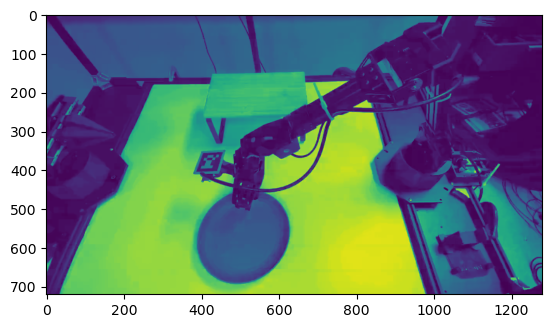

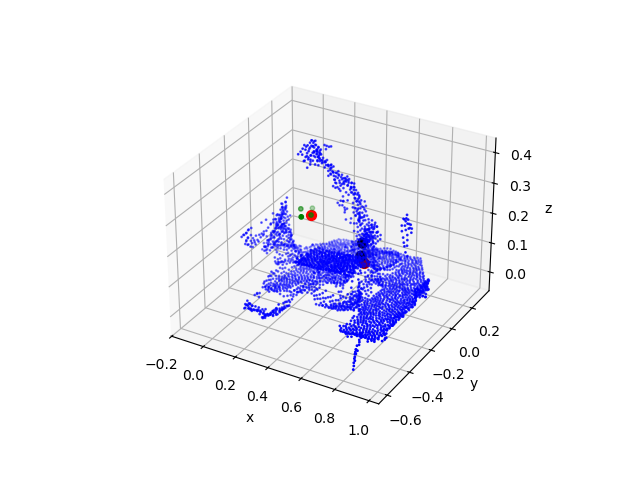

> /tmp/ipykernel_646316/2773695507.py(63)<module>()
     61 
     62 
---> 63     for t_idx in range(from_idx, to_idx):
     64 
     65         print(f"Processing traj {traj_idx}, frame_idx {t_idx - from_idx} / {traj_len}")



ipdb>  q


In [3]:
### NOTE: load camera intrinsics and extrinsics
all_intrinsics = []
all_extrinsics = []
cameras = {
  "cam_azure_kinect_front": {
    "intrinsics": "/data/yufei/lerobot/lerobot/scripts/aloha_calibration/intrinsics_000259921812.txt",
    "extrinsics": "/data/yufei/lerobot/lerobot/scripts/aloha_calibration/T_world_from_camera_front_v1_1020.txt"
  },
  "cam_azure_kinect_back": {
    "intrinsics": "/data/yufei/lerobot/lerobot/scripts/aloha_calibration/intrinsics_000003493812.txt",
    "extrinsics": "/data/yufei/lerobot/lerobot/scripts/aloha_calibration/T_world_from_camera_back_v1_1020.txt"
  }
}
for cam_name, cam_cfg in cameras.items():
    # Load intrinsics
    K = _load_camera_intrinsics(cam_cfg['intrinsics'])
    # K_scaled = BaseDataset.get_scaled_intrinsics(
    #     K, orig_shape, target_shape
    # )
    all_intrinsics.append(K)
    # print(f"Loaded intrinsics for cam_name: {cam_name}: {K}")

    # Load extrinsics
    T = _load_camera_extrinsics(cam_cfg['extrinsics'])
    all_extrinsics.append(T)
    # print(f"Loaded extrinsics for cam_name: {cam_name}: {T}")

num_points = 4500
max_depth = 1.5

for traj_idx in range(2, dataset.num_episodes):
    
    traj_eef_pose = []
    traj_gripper_pcd = []
    traj_scene_pcd = []
    traj_goal_gripper_pcd = []
    
    from_idx = dataset.episode_data_index["from"][traj_idx].item()
    to_idx = dataset.episode_data_index["to"][traj_idx].item()
    traj_len = to_idx - from_idx
    print(f"Trajectory {traj_idx} has length {traj_len} from {from_idx} to {to_idx}")
    # for t_idx in range(from_idx, to_idx):
    #     dataset_idx =  t_idx
    #     data_point = dataset[dataset_idx]
    #     print(f"processing traj {traj_idx} dataset idx {t_idx} frame idx {t_idx - from_idx}, which is labeled to be traj {data_point['episode_index']} and frame idx {data_point['frame_index']}")
    #     assert data_point['episode_index'].item() == traj_idx
    # exit()

    all_eef_pose = [dataset[t_idx]['observation.right_eef_pose'] for t_idx in range(from_idx, to_idx)]
    all_gripper_finger_widths = [x[-1].item() for x in all_eef_pose]
    all_gripper_finger_widths = np.array(all_gripper_finger_widths)
    finger_diff = all_gripper_finger_widths[1: ] - all_gripper_finger_widths[:-1]
        
    # print(f"max finger width: {np.max(all_gripper_finger_widths)}")
    # print("finger diff is: ", finger_diff)

    # plt.close("all")
    # # plt.plot(range(len(all_gripper_finger_widths)), all_gripper_finger_widths)
    # plt.plot(range(len(finger_diff)), finger_diff)
    # plt.show()

    
    for t_idx in range(from_idx, to_idx):
        
        print(f"Processing traj {traj_idx}, frame_idx {t_idx - from_idx} / {traj_len}")
        
        dataset_idx = t_idx
        data_point = dataset[dataset_idx]
        
        right_eef_pose = data_point['observation.right_eef_pose']#.cpu().numpy()  # (state_dim,)     
        eef_pos, eef_rot_6d, eef_gripper_width, eef_pos_robot_base, eef_rot_matrix_robot_base, eef_rot_6d_robot_base, eef_gripper_width_franka = get_gripper_4_points_from_sriram_data(right_eef_pose)
        
        traj_eef_pose.append(np.array([*eef_pos_robot_base, *eef_rot_6d_robot_base, *eef_gripper_width_franka]))
        
        ### NOTE: perform the conversion from the gripper pose to the gripper 4 points
        eef_4_points = get_4_points_from_gripper_pos_orient(eef_pos_robot_base, eef_rot_matrix_robot_base, eef_gripper_width_franka)
    
        ### NOTE: get the scene point cloud from the depth image
        depth_keys = ["observation.images.cam_azure_kinect_front.transformed_depth", "observation.images.cam_azure_kinect_back.transformed_depth"]
        all_cam_depth_images = []
        for depth_key in depth_keys:
            depth = Image.fromarray(data_point[depth_key].numpy()[0])
            depth = np.asarray(depth)
            all_cam_depth_images.append(depth)
            
        # import pdb; pdb.set_trace()    
        %matplotlib inline
        import matplotlib.pyplot as plt
        # plt.imshow(all_cam_depth_images[0])
        # plt.show()

        %matplotlib widget
        from matplotlib import pyplot as plt
        all_pcd_in_world = []
        for (depth, intrisincs, extrinsics) in zip(all_cam_depth_images, all_intrinsics, all_extrinsics):
            pcd_in_camera = get_scene_pcd_cam_frame(
                depth, intrisincs, None, max_depth
            )
            
            pcd_in_world = transform_to_world_frame(pcd_in_camera, extrinsics)
            
            ### use open3d to visualize the point cloud
            x = pcd_in_world[pcd_in_world[:, 1] < 0.6]
            x = x[x[:, 1] > -0.4]
            
            x_in_robot_base = transform_from_table_center_to_robot_base(x)
            
            # fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'})
            # ### Plot in table coordinate
            # ax = axes[0]
            # ax.scatter(x[:, 0], x[:, 1], x[:, 2], s=1, color='blue')
            # ax.scatter([0], [0], [0], s=50, color='red')
            # ax.scatter([eef_pos[0]], [eef_pos[1]], [eef_pos[2]], s=50, color='red')
            # ax.set_xlabel("x")
            # ax.set_ylabel("y")
            # ax.set_zlabel("z")
            
            # ### plot in robot base coordinate
            # ax = axes[1]
            # ax.scatter(x_in_robot_base[:, 0], x_in_robot_base[:, 1], x_in_robot_base[:, 2], s=1, color='blue')
            # ax.scatter([0], [0], [0], s=50, color='red')
            # ax.scatter([eef_pos_robot_base[0]], [eef_pos_robot_base[1]], [eef_pos_robot_base[2]], s=50, color='red')
            # ax.scatter(eef_4_points[:, 0], eef_4_points[:, 1], eef_4_points[:, 2], s=10, color='green')
            # ax.set_xlabel("x")
            # ax.set_ylabel("y")
            # ax.set_zlabel("z")
            
            # plt.show()
        
            # import pdb; pdb.set_trace()
            all_pcd_in_world.append(x_in_robot_base)
        
        
        all_pcd_in_world = np.concatenate(all_pcd_in_world, axis=0)  # (num_cams * num_points, 3)

        ### perform fps here
        # all_pcd_in_world = get_fps_pcd(torch.from_numpy(all_pcd_in_world).unsqueeze(0), num_points)
        all_pcd_in_world = fpsample_pcd(all_pcd_in_world, num_points)

        print("all_pcd_in_world shape:", all_pcd_in_world.shape)
        traj_scene_pcd.append(all_pcd_in_world)
        # ax = plt.subplot(projection='3d')
        # ax.scatter(all_pcd_in_world[:, 0], all_pcd_in_world[:, 1], all_pcd_in_world[:, 2], s=1, color='blue')
        # plt.show()
        
        ### NOTE: get the goal event idx, goal eef pose and convert that to the goal gripper pcd
        episode_index = data_point["episode_index"].item()
        assert episode_index == traj_idx
        assert data_point["frame_index"].item() == t_idx - from_idx
        # The next_event_idx is relative to the episode, so we calculate the absolute index
        goal_idx = (
            data_point["next_event_idx"] - data_point["frame_index"] + dataset_idx
        ).item()
        
        goal_idx_2 = data_point['next_event_idx'].item() + from_idx
        assert goal_idx == goal_idx_2

        print("relative first goal idx is: ", data_point["next_event_idx"] )
        print("first goal idx is: ", goal_idx)

        # continue
        
        goal_data_point = dataset[goal_idx]
        rgb_image = Image.fromarray(goal_data_point['observation.images.cam_azure_kinect_front.color'].numpy()[0])
        rgb_image = np.asarray(rgb_image)
        %matplotlib inline
        import matplotlib.pyplot as plt
        plt.imshow(rgb_image)
        plt.show()
        goal_right_eef_pose = goal_data_point['observation.right_eef_pose']  # (state_dim,)

        depth_key = "observation.images.cam_azure_kinect_front.transformed_depth"
        goal_depth = Image.fromarray(goal_data_point[depth_key].numpy()[0])
        goal_depth = np.asarray(goal_depth)
        goal_pcd_in_camera = get_scene_pcd_cam_frame(
                goal_depth, all_intrinsics[0], num_points, max_depth
        )
        goal_pcd_in_world = transform_to_world_frame(goal_pcd_in_camera, all_extrinsics[0])
        ### use open3d to visualize the point cloud
        goal_x = goal_pcd_in_world[goal_pcd_in_world[:, 1] < 0.6]
        goal_x = goal_x[goal_x[:, 1] > -0.4]
        goal_x_in_robot_base = transform_from_table_center_to_robot_base(goal_x)
        

        goal_eef_pos, goal_eef_rot_6d, goal_eef_gripper_width, goal_eef_pos_robot_base, goal_eef_rot_matrix_robot_base, goal_eef_rot_6d_robot_base, goal_eef_gripper_width_franka =\
            get_gripper_4_points_from_sriram_data(goal_right_eef_pose)
        goal_4_points = get_4_points_from_gripper_pos_orient(goal_eef_pos_robot_base, goal_eef_rot_matrix_robot_base, goal_eef_gripper_width_franka)
        %matplotlib widget
        from matplotlib import pyplot as plt
        plt.close("all")
        ax = plt.subplot(projection='3d')
        # ax.scatter(all_pcd_in_world[:, 0], all_pcd_in_world[:, 1], all_pcd_in_world[:, 2], s=1, color='blue')
        ax.scatter(goal_x_in_robot_base[:, 0], goal_x_in_robot_base[:, 1], goal_x_in_robot_base[:, 2], s=1, color='blue')
        ax.scatter([eef_pos_robot_base[0]], [eef_pos_robot_base[1]], [eef_pos_robot_base[2]], s=50, color='red')
        ax.scatter(eef_4_points[:, 0], eef_4_points[:, 1], eef_4_points[:, 2], s=10, color='green')
        ax.scatter([goal_eef_pos_robot_base[0]], [goal_eef_pos_robot_base[1]], [goal_eef_pos_robot_base[2]], s=50, color='red')
        ax.scatter(goal_4_points[:, 0], goal_4_points[:, 1], goal_4_points[:, 2], s=50, color='black')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        plt.show()

        import pdb; pdb.set_trace()
        
    ### for action: check the magnitude of our dataset and make sure we have similar action magnitudes
    ### maybe merge actions
    traj_eef_pose = np.stack(traj_eef_pose, axis=0)  # (traj_len, 10)
    all_delta_translations = traj_eef_pose[1:, :3] - traj_eef_pose[:-1, :3]  # (traj_len - 1, 3)
    all_delta_translations_magnitudes = np.linalg.norm(all_delta_translations, axis=1)  # (traj_len - 1,)
    print("mean translation delta:", np.mean(all_delta_translations_magnitudes))
    print("max translation delta:", np.max(all_delta_translations_magnitudes))
    print("min translation delta:", np.min(all_delta_translations_magnitudes))
    
    exit()
        